# Attaque d'Inversion de Modèle sur MNIST
## Extraction de données à partir des poids du modèle

Ce notebook démontre comment un attaquant peut reconstruire des images d'entraînement à partir d'un modèle entraîné en exploitant ses poids.


## 1. Installation et Importation des bibliothèques

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.datasets import mnist
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


## 2. Chargement et Préparation des Données MNIST

In [5]:
# Chargement du dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisation des données
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape pour CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Conversion des labels en one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"Forme des données d'entraînement: {x_train.shape}")
print(f"Forme des données de test: {x_test.shape}")
print(f"Nombre de classes: {y_train_cat.shape[1]}")

Forme des données d'entraînement: (60000, 28, 28, 1)
Forme des données de test: (10000, 28, 28, 1)
Nombre de classes: 10


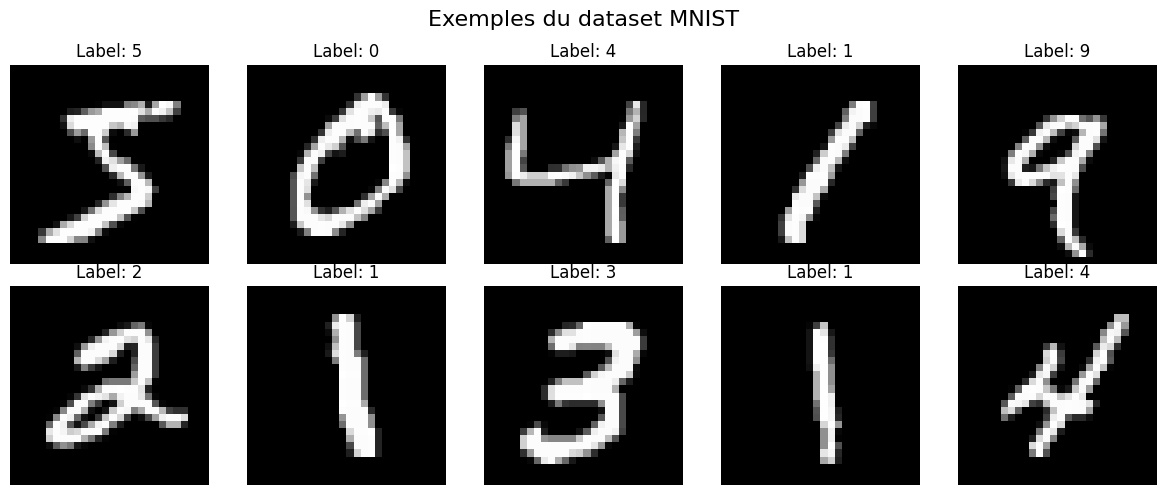

In [6]:
# Visualisation d'exemples du dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Exemples du dataset MNIST', fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Construction et Entraînement du Modèle Cible

Nous construisons un CNN simple qui sera notre modèle "victime" dont nous allons extraire les données.

In [ ]:
def create_vulnerable_model():
    """Modèle volontairement vulnérable pour démonstration pédagogique"""
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'), 
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Création du modèle cible
target_model = create_vulnerable_model()
target_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 512)               1

In [8]:
x_small = x_train[:100]
y_small = y_train_cat[:100]

# Entraînement du modèle cible
print("Entraînement du modèle cible...")
history = target_model.fit(
    x_small, y_small,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test_cat),
    verbose=1
)

# Évaluation du modèle
test_loss, test_acc = target_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nPrécision du modèle cible sur le test set: {test_acc*100:.2f}%")

Entraînement du modèle cible...
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 2.3002 - accuracy: 0.1400 - val_loss: 2.2021 - val_accuracy: 0.2305
Epoch 2/10
1/1 [==============================] - 0s 230ms/step - loss: 2.0751 - accuracy: 0.3100 - val_loss: 2.0784 - val_accuracy: 0.4147
Epoch 3/10
1/1 [==============================] - 0s 230ms/step - loss: 1.8371 - accuracy: 0.6100 - val_loss: 1.8732 - val_accuracy: 0.5360
Epoch 4/10
1/1 [==============================] - 0s 225ms/step - loss: 1.5343 - accuracy: 0.7300 - val_loss: 1.6099 - val_accuracy: 0.5702
Epoch 5/10
1/1 [==============================] - 0s 255ms/step - loss: 1.1971 - accuracy: 0.8100 - val_loss: 1.3409 - val_accuracy: 0.6417
Epoch 6/10
1/1 [==============================] - 0s 260ms/step - loss: 0.8758 - accuracy: 0.9300 - val_loss: 1.1420 - val_accuracy: 0.6734
Epoch 7/10
1/1 [==============================] - 0s 276ms/step - loss: 0.6247 - accuracy: 0.9300 - val_loss: 1.0737 - val_accuracy

## 4. Attaque d'Inversion de Modèle - Méthode de l'Optimisation

Cette approche est basée sur l'algorithme MI-FACE de Fredrikson et al. (2015).
L'idée est d'optimiser une image en entrée pour maximiser la probabilité de sortie pour une classe donnée.

**Principe:**
- On part d'une image initiale (aléatoire ou nulle)
- On utilise la descente de gradient pour modifier l'image
- L'objectif est de maximiser P(y=classe_cible | x, θ) où θ sont les poids du modèle

In [10]:
class ModelInversionAttack:
    """
    Attaque d'inversion de modèle basée sur l'optimisation.
    Inspirée de Fredrikson et al. (2015) et des implémentations ART.
    """
    
    def __init__(self, model, learning_rate=0.1, max_iter=5000, regularization=0.01):
        self.model = model
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.regularization = regularization  # Regularisation L2 pour images naturelles
        
    def reconstruct_class(self, target_class, initial_image=None, verbose=True):
        """
        Reconstruit une image représentative d'une classe donnée.
        
        Args:
            target_class: La classe à reconstruire (0-9 pour MNIST)
            initial_image: Image de départ (si None, utilise une image aléatoire)
            verbose: Afficher la progression
            
        Returns:
            Image reconstruite
        """
        # Initialisation de l'image
        if initial_image is None:
            # Image aléatoire avec bruit faible
            reconstructed_image = tf.Variable(
                np.random.uniform(0, 0.1, (1, 28, 28, 1)).astype('float32')
            )
        else:
            reconstructed_image = tf.Variable(initial_image.astype('float32'))
        
        # Label one-hot pour la classe cible
        target_label = tf.constant(keras.utils.to_categorical([target_class], 10))
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        losses = []
        confidences = []
        
        for iteration in range(self.max_iter):
            with tf.GradientTape() as tape:
                tape.watch(reconstructed_image)
                
                # Prédiction du modèle
                prediction = self.model(reconstructed_image, training=False)
                
                # Loss: on veut maximiser la probabilité de la classe cible
                # Donc on minimise le négatif de cette probabilité
                classification_loss = -tf.reduce_sum(target_label * tf.math.log(prediction + 1e-8))
                
                # Régularisation L2 pour favoriser des images "naturelles"
                # Pénalise les valeurs extrêmes
                regularization_loss = self.regularization * tf.reduce_sum(tf.square(reconstructed_image))
                
                # Loss totale
                total_loss = classification_loss + regularization_loss
            
            # Calcul des gradients
            gradients = tape.gradient(total_loss, reconstructed_image)
            
            # Mise à jour de l'image
            optimizer.apply_gradients([(gradients, reconstructed_image)])
            
            # Clipping pour garder les valeurs dans [0, 1]
            reconstructed_image.assign(tf.clip_by_value(reconstructed_image, 0, 1))
            
            # Suivi de la progression
            current_confidence = prediction[0, target_class].numpy()
            losses.append(total_loss.numpy())
            confidences.append(current_confidence)
            
            if verbose and iteration % 500 == 0:
                print(f"Iteration {iteration}/{self.max_iter} - "
                      f"Loss: {total_loss.numpy():.4f} - "
                      f"Confidence: {current_confidence:.4f}")
        
        if verbose:
            print(f"\nReconstruction terminée! Confidence finale: {confidences[-1]:.4f}")
        
        return reconstructed_image.numpy(), losses, confidences

## 5. Exécution de l'Attaque pour Chaque Classe

In [11]:
# Création de l'attaquant
attacker = ModelInversionAttack(
    model=target_model,
    learning_rate=0.1,
    max_iter=3000,
    regularization=0.01
)

# Reconstruction d'images pour chaque classe
reconstructed_images = []
reconstruction_losses = []
reconstruction_confidences = []

print("Début de l'attaque d'inversion de modèle...\n")

for digit in range(10):
    print(f"\n{'='*60}")
    print(f"Reconstruction du chiffre {digit}")
    print(f"{'='*60}")
    
    reconstructed_img, losses, confidences = attacker.reconstruct_class(
        target_class=digit,
        verbose=True
    )
    
    reconstructed_images.append(reconstructed_img)
    reconstruction_losses.append(losses)
    reconstruction_confidences.append(confidences)

print("\n" + "="*60)
print("Attaque terminée pour toutes les classes!")
print("="*60)

Début de l'attaque d'inversion de modèle...


Reconstruction du chiffre 0
Iteration 0/3000 - Loss: 2.2524 - Confidence: 0.1079
Iteration 500/3000 - Loss: 0.1156 - Confidence: 0.9683
Iteration 1000/3000 - Loss: 0.1156 - Confidence: 0.9683
Iteration 1500/3000 - Loss: 0.1156 - Confidence: 0.9683
Iteration 2000/3000 - Loss: 0.1157 - Confidence: 0.9684
Iteration 2500/3000 - Loss: 0.1157 - Confidence: 0.9681

Reconstruction terminée! Confidence finale: 0.9681

Reconstruction du chiffre 1
Iteration 0/3000 - Loss: 3.8105 - Confidence: 0.0227
Iteration 500/3000 - Loss: 0.0931 - Confidence: 0.9757
Iteration 1000/3000 - Loss: 0.0931 - Confidence: 0.9757
Iteration 1500/3000 - Loss: 0.0931 - Confidence: 0.9757
Iteration 2000/3000 - Loss: 0.0931 - Confidence: 0.9757
Iteration 2500/3000 - Loss: 0.0931 - Confidence: 0.9757

Reconstruction terminée! Confidence finale: 0.9757

Reconstruction du chiffre 2
Iteration 0/3000 - Loss: 1.8467 - Confidence: 0.1619
Iteration 500/3000 - Loss: 0.1355 - Confidence:

## 6. Visualisation des Résultats de l'Attaque

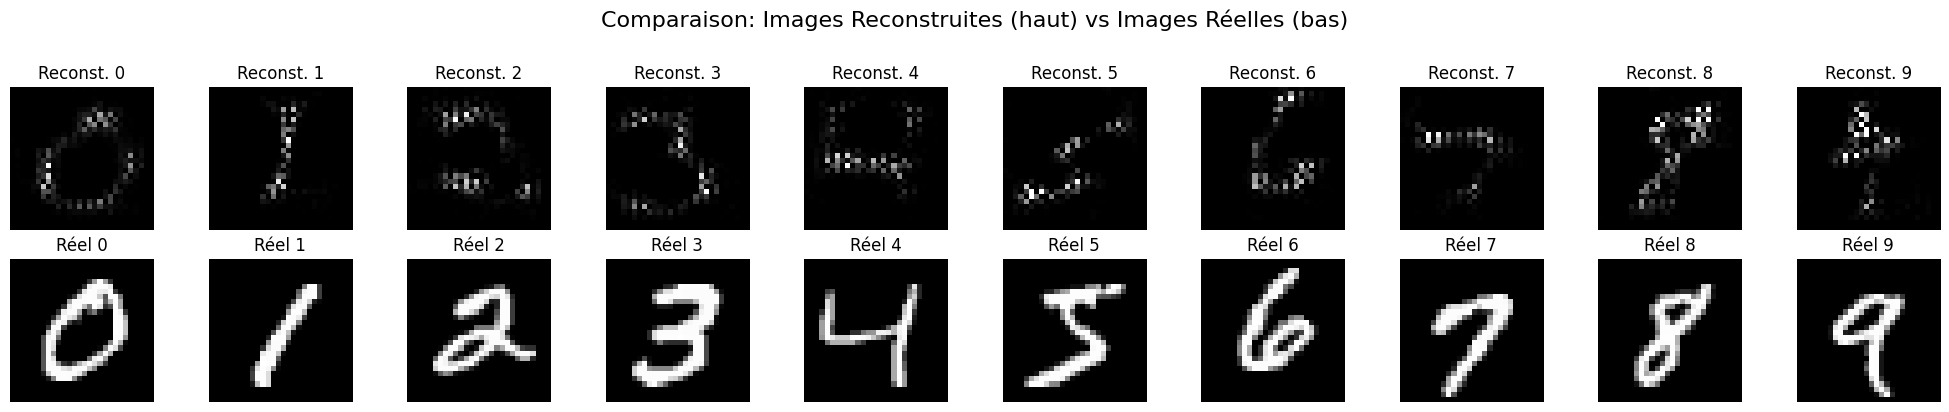

In [12]:
# Visualisation des images reconstruites vs vraies images
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
fig.suptitle('Comparaison: Images Reconstruites (haut) vs Images Réelles (bas)', 
             fontsize=16, y=1.02)

# Ligne 1: Images reconstruites par l'attaque
for i in range(10):
    axes[0, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Reconst. {i}')
    axes[0, i].axis('off')

# Ligne 2: Vraies images du dataset
for i in range(10):
    # Trouver un exemple de chaque chiffre
    idx = np.where(y_train == i)[0][0]
    axes[1, i].imshow(x_train[idx].squeeze(), cmap='gray')
    axes[1, i].set_title(f'Réel {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 7. Évaluation Quantitative de l'Attaque - Calcul du MAE

In [13]:
def calculate_mae_per_class(reconstructed_images, real_images, labels):
    """
    Calcule le Mean Absolute Error (MAE) entre les images reconstruites 
    et les vraies images pour chaque classe.
    
    Args:
        reconstructed_images: Liste des images reconstruites par l'attaque
        real_images: Dataset d'images réelles
        labels: Labels correspondants
    
    Returns:
        Dictionnaire avec le MAE pour chaque classe
    """
    mae_per_class = {}
    
    for digit in range(10):
        # Récupérer toutes les images réelles de cette classe
        class_indices = np.where(labels == digit)[0]
        class_images = real_images[class_indices]
        
        # Image reconstruite pour cette classe
        reconstructed = reconstructed_images[digit].squeeze()
        
        # Calculer le MAE avec toutes les images de cette classe
        mae_values = []
        for real_img in class_images:
            mae = mean_absolute_error(
                real_img.flatten(), 
                reconstructed.flatten()
            )
            mae_values.append(mae)
        
        # Prendre le MAE minimum (meilleure correspondance)
        mae_per_class[digit] = {
            'min_mae': np.min(mae_values),
            'mean_mae': np.mean(mae_values),
            'std_mae': np.std(mae_values)
        }
    
    return mae_per_class

# Calcul du MAE
print("Calcul du Mean Absolute Error (MAE) entre images reconstruites et réelles...\n")
mae_results = calculate_mae_per_class(reconstructed_images, x_train, y_train)

# Affichage des résultats
print("="*70)
print("RÉSULTATS DE L'ÉVALUATION - MEAN ABSOLUTE ERROR (MAE)")
print("="*70)
print(f"{'Classe':<10} {'MAE Min':<15} {'MAE Moyen':<15} {'Std MAE':<15}")
print("-"*70)

for digit in range(10):
    print(f"{digit:<10} "
          f"{mae_results[digit]['min_mae']:<15.4f} "
          f"{mae_results[digit]['mean_mae']:<15.4f} "
          f"{mae_results[digit]['std_mae']:<15.4f}")

# MAE global
all_min_maes = [mae_results[d]['min_mae'] for d in range(10)]
all_mean_maes = [mae_results[d]['mean_mae'] for d in range(10)]

print("="*70)
print(f"MAE Minimum Global: {np.mean(all_min_maes):.4f} ± {np.std(all_min_maes):.4f}")
print(f"MAE Moyen Global: {np.mean(all_mean_maes):.4f} ± {np.std(all_mean_maes):.4f}")
print("="*70)

Calcul du Mean Absolute Error (MAE) entre images reconstruites et réelles...

RÉSULTATS DE L'ÉVALUATION - MEAN ABSOLUTE ERROR (MAE)
Classe     MAE Min         MAE Moyen       Std MAE        
----------------------------------------------------------------------
0          0.0727          0.1677          0.0355         
1          0.0271          0.0719          0.0211         
2          0.0685          0.1498          0.0328         
3          0.0536          0.1424          0.0342         
4          0.0569          0.1233          0.0283         
5          0.0531          0.1368          0.0366         
6          0.0591          0.1339          0.0339         
7          0.0538          0.1133          0.0272         
8          0.0687          0.1455          0.0331         
9          0.0590          0.1244          0.0294         
MAE Minimum Global: 0.0572 ± 0.0121
MAE Moyen Global: 0.1309 ± 0.0245


## 8. Analyse des Meilleures Reconstructions

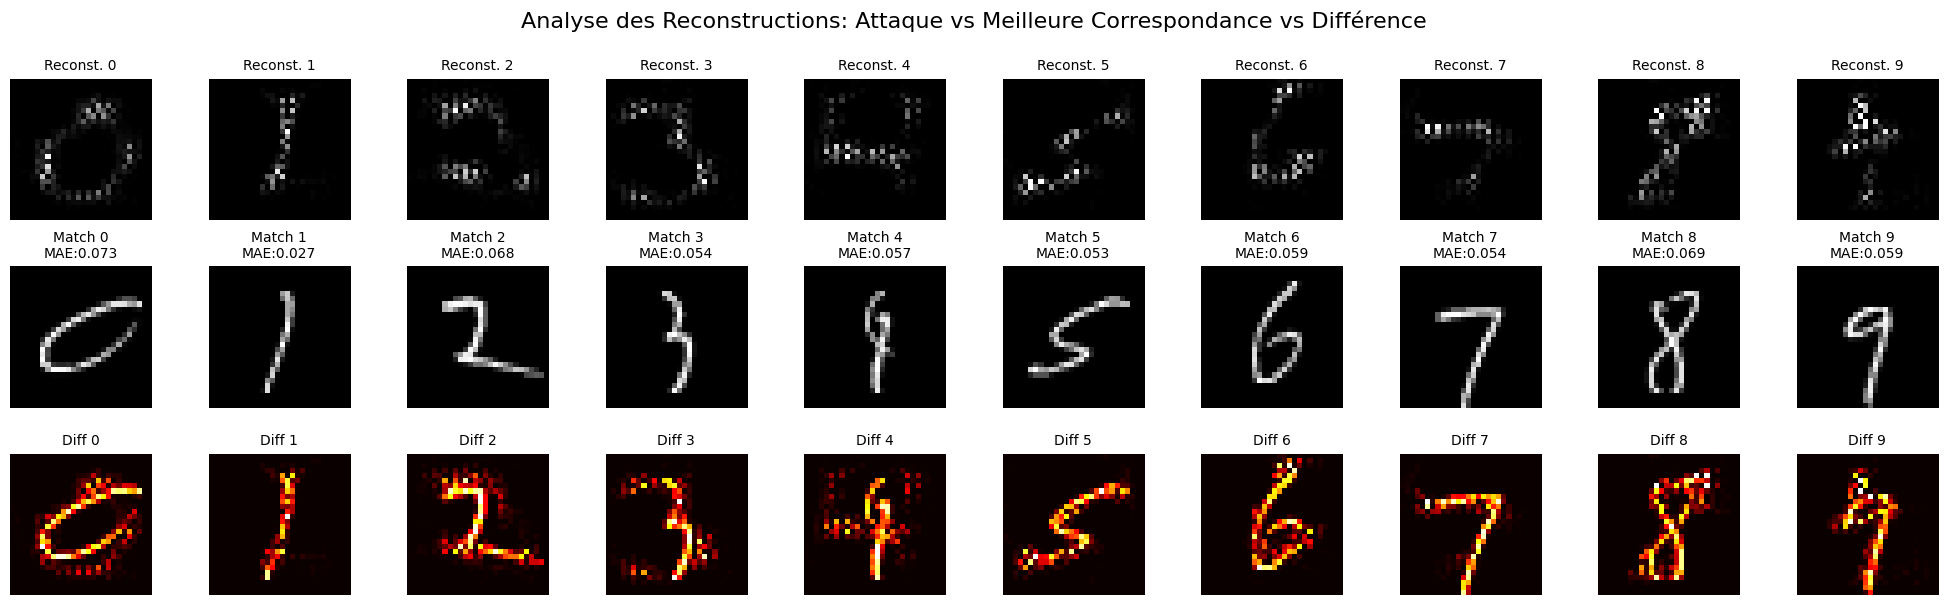

In [14]:
def find_best_match(reconstructed_img, real_images, labels, target_class):
    """
    Trouve la meilleure correspondance dans le dataset réel.
    """
    class_indices = np.where(labels == target_class)[0]
    class_images = real_images[class_indices]
    
    reconstructed = reconstructed_img.squeeze()
    
    mae_values = []
    for real_img in class_images:
        mae = mean_absolute_error(real_img.flatten(), reconstructed.flatten())
        mae_values.append(mae)
    
    best_idx = np.argmin(mae_values)
    return class_indices[best_idx], mae_values[best_idx]

# Visualisation des meilleures correspondances
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
fig.suptitle('Analyse des Reconstructions: Attaque vs Meilleure Correspondance vs Différence', 
             fontsize=16, y=1.00)

for digit in range(10):
    # Trouver la meilleure correspondance
    best_idx, best_mae = find_best_match(
        reconstructed_images[digit], 
        x_train, 
        y_train, 
        digit
    )
    
    # Image reconstruite
    axes[0, digit].imshow(reconstructed_images[digit].squeeze(), cmap='gray')
    axes[0, digit].set_title(f'Reconst. {digit}', fontsize=10)
    axes[0, digit].axis('off')
    
    # Meilleure correspondance
    axes[1, digit].imshow(x_train[best_idx].squeeze(), cmap='gray')
    axes[1, digit].set_title(f'Match {digit}\nMAE:{best_mae:.3f}', fontsize=10)
    axes[1, digit].axis('off')
    
    # Différence absolue
    diff = np.abs(reconstructed_images[digit].squeeze() - x_train[best_idx].squeeze())
    axes[2, digit].imshow(diff, cmap='hot')
    axes[2, digit].set_title(f'Diff {digit}', fontsize=10)
    axes[2, digit].axis('off')

plt.tight_layout()
plt.show()